# Naive Bayes

Goal: a classifier of text blocks (blank line separated) into classes of alice in wonderland or shakespeare. Specifically using a Naive Bayes classifier.

Naive Bayes is a simple probabilistic classifier based on the frequency of words in a document, as associated to a class.

In [17]:
import random
import math
import matplotlib.pyplot as plt 
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score


random.seed(42)


# Prepare data

1. Load the two class documents as blocks of text
2. Split into training and test sets
3. Determine the vocabulary of the training set

In [18]:
IS_NOT_SHAKESPEARE = 0
IS_SHAKESPEARE = 1

def _load_blocks(filename):
    print('Loading ' + filename)
    all_blocks = []
    with open(filename, 'r', encoding="mbcs") as file:
        current_block = ''
        for line in file:
            line = line.strip().casefold()
            if len(line) > 0:
                current_block = f'{current_block} {line}'
            elif len(line) == 0 and len(current_block) > 0:
                all_blocks.append(current_block)
                current_block = ''
    return all_blocks

def _training_test_split(data):
    TRAINING_SPLIT = 0.8
    training_data = data[:int(len(data) * TRAINING_SPLIT)] 
    test_data = data[int(len(data) * TRAINING_SPLIT):]
    return training_data, test_data

def _combine_and_shuffle_datasets(dataset_1, dataset_2):
    combined_dataset = dataset_1 + dataset_2
    return random.sample(combined_dataset, len(combined_dataset))

def _load_test_training_data():
    alice_dataset = [(block, IS_NOT_SHAKESPEARE) for block in _load_blocks('./datasets/Alice.txt')]
    shakespeare_dataset = [(block, IS_SHAKESPEARE) for block in _load_blocks('./datasets/Shakespear.txt')]
    training_alice_dataset, test_alice_dataset = _training_test_split(alice_dataset)
    training_shakespeare_dataset, test_shakespeare_dataset = _training_test_split(shakespeare_dataset)
    training_set = _combine_and_shuffle_datasets(training_alice_dataset, training_shakespeare_dataset)
    test_set = _combine_and_shuffle_datasets(test_alice_dataset, test_shakespeare_dataset)
    return training_set, test_set

training_set, test_set = _load_test_training_data()
print(f'Training set size: {len(training_set)}. Test set size: {len(test_set)}')
vocabulary = {word for block, _ in training_set for word in block.split()}
print(f'Vocabulary size: {len(vocabulary)}')

Loading ../Word2Vec/Alice.txt
Loading ../Word2Vec/Shakespear.txt


Training set size: 6011. Test set size: 1504
Vocabulary size: 54319


## Train

Calculate probabilities of each vocabulary word for each class.

In [82]:
CLASSES = [IS_NOT_SHAKESPEARE, IS_SHAKESPEARE]

def _calculate_probability_of_class(dataset, class_index):
    return sum([1 for _, block_class in dataset if block_class == class_index]) / len(dataset)

def _calculate_probability_of_word_given_class(dataset_words_frequencies_per_class, class_words_count, vocabulary_size, target_word, class_index, alpha=0.1):
    words_in_class_count_plus_laplaces = class_words_count[class_index] + alpha * vocabulary_size
    word_in_class_count_plus_laplace = dataset_words_frequencies_per_class[class_index][target_word] + alpha
    return word_in_class_count_plus_laplace / words_in_class_count_plus_laplaces
    
def _calculate_probabilities(dataset):
    probability_of_classes = [_calculate_probability_of_class(dataset, class_index) for class_index in CLASSES] 
    dataset_word_frequencies_per_class = _calculate_word_frequencies_per_class(dataset)
    class_words_count = [sum(dataset_word_frequencies_per_class[class_index].values()) for class_index in CLASSES]
    probability_of_word_given_class = [
        {
            word: _calculate_probability_of_word_given_class(dataset_word_frequencies_per_class, class_words_count, len(vocabulary), word, class_index) 
            for word in vocabulary
        }
        for class_index in CLASSES
    ]
    
    return probability_of_classes, probability_of_word_given_class

def _calculate_word_frequencies_per_class(dataset):
    dataset_word_frequencies_per_class = [{word: 0 for word in vocabulary} for _ in CLASSES]
    for block, block_class in dataset:
        for word in block.split():
            dataset_word_frequencies_per_class[block_class][word] += 1
    return dataset_word_frequencies_per_class

prob_class, prob_word_given_class = _calculate_probabilities(training_set)

print(f'Class probabilities: {prob_class}')
print(f'Word probabilities count: {len(prob_word_given_class[IS_NOT_SHAKESPEARE])}')

Class probabilities: [0.11661953086008983, 0.8833804691399102]
Word probabilities count: 54319


## Classify

For each test document, calculate the likelihood it is from each class, based on word probabilities per class, and choose the class with the highest likelihood.

The equation is:

$$
P(class|doc) = P(class) \times \prod_{word \in doc} P(word|class)
$$

Or in log form (to avoid the float underflow problem in sequential multiplication of fractions):
$$
\log(P(class|doc)) = \log(P(class)) + \sum_{word \in doc} \log(P(word|class))
$$

Note that $\log(P(class|doc))$ is proportional to $P(class|doc)$, so we can use the log likelihoods to compare classes.

Where:
- $P(class)$ is the prior probability of the class
- $P(word|class)$ is the probability of the word given the class
- $P(class|doc)$ is the posterior probability of the class given the document

In [84]:
def _calculate_class_likelihood_for_block(vocabulary, prob_word_given_class, prob_class, class_index, block):
    log_class_probability = math.log10(prob_class[class_index])
    totalled_log_word_probabilities_in_class = sum([math.log10(prob_word_given_class[class_index][word]) for word in block.split() if word in vocabulary])
    return log_class_probability + totalled_log_word_probabilities_in_class

def _calculate_block_likelihoods(test_set, vocabulary, prob_word_given_class, prob_class):
    return [(
        [
            _calculate_class_likelihood_for_block(vocabulary, prob_word_given_class, prob_class, class_index, block)
            for class_index in CLASSES
        ], 
        actual_class) 
    for block, actual_class in test_set 
]

def _map_likelihoods_to_predictions(block_likelihoods):
    return [
    ( 
        (IS_SHAKESPEARE if likelihoods[0] < likelihoods[1] else IS_NOT_SHAKESPEARE), 
        actual_class)
    for likelihoods, actual_class in block_likelihoods]


block_likelihoods = _calculate_block_likelihoods(test_set, vocabulary, prob_word_given_class, prob_class)
block_class_predictions_and_actuals = _map_likelihoods_to_predictions(block_likelihoods)
predicted_class = [predicted_class for predicted_class, _ in  block_class_predictions_and_actuals]
actual_class = [actual_class for _, actual_class in  block_class_predictions_and_actuals]
accuracy = accuracy_score(actual_class, predicted_class)
balanced_accuracy = balanced_accuracy_score(actual_class, predicted_class)
print(f'Accuracy: {accuracy}. Balanced accuracy: {balanced_accuracy}')

Accuracy: 0.9634308510638298. Balanced accuracy: 0.8462144030668127


## Visualise

This confusion matrix show that this basic Naive Bayes model is reasonably effective at classifying the two types of file. But there is one notable exception, which is the Alice in Wonderland precision.

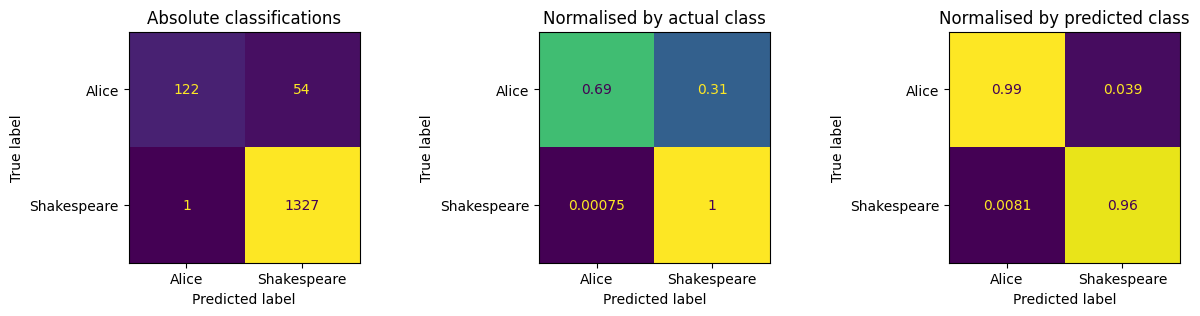

In [80]:
CLASS_NAMES = ['Alice', 'Shakespeare']

def display_confusion_matrix(ax, class_labels, predicted_class, actual_class, normalize, title):
    ConfusionMatrixDisplay.from_predictions(
        actual_class,
        predicted_class, 
        display_labels=class_labels, 
        ax=ax,
        normalize=normalize,
        colorbar=False)
    ax.set_title(title)

figure, axes = plt.subplots(1, 3, figsize=(15, 3))
display_confusion_matrix(axes[0], CLASS_NAMES, predicted_class, actual_class, normalize=None, title='Absolute classifications')
display_confusion_matrix(axes[1], CLASS_NAMES, predicted_class, actual_class, normalize='true', title='Normalised by actual class')
display_confusion_matrix(axes[2], CLASS_NAMES, predicted_class, actual_class, normalize='pred', title='Normalised by predicted class')
plt.show()

# Misclassified documents

The following are some of the misclassified documents, which show that the model is struggling to classify the copyright metadata embedded in the Alice in Wonderland text. This is the cause of the low precision for Alice in Wonderland, and could be rectified by cleaning the metadata from the dataset.

In [81]:
test_set_misclassified = [(block, (predicted_class, actual_class)) for (block, (predicted_class, actual_class)) in zip(test_set, block_class_predictions_and_actuals) if predicted_class != actual_class]
print(f'Misclassified blocks: {len(test_set_misclassified)}')

for block, (predicted_class, actual_class) in test_set_misclassified[:5]:
    print('---')
    print(f'Predicted class: {predicted_class}. Actual class: {actual_class}')
    print(f'Block: {block[0]}')

Missclassified blocks: 55
---
Predicted class: 1. Actual class: 0
Block:  1.e.3. if an individual project gutenberg-tm electronic work is posted with the permission of the copyright holder, your use and distribution must comply with both paragraphs 1.e.1 through 1.e.7 and any additional terms imposed by the copyright holder. additional terms will be linked to the project gutenberg-tm license for all works posted with the permission of the copyright holder found at the beginning of this work.
---
Predicted class: 1. Actual class: 0
Block:  start: full license
---
Predicted class: 1. Actual class: 0
Block:  1.d. the copyright laws of the place where you are located also govern what you can do with this work. copyright laws in most countries are in a constant state of change. if you are outside the united states, check the laws of your country in addition to the terms of this agreement before downloading, copying, displaying, performing, distributing or creating derivative works based on 